In [2]:
import numpy as np
from scipy import stats
from scipy.sparse import coo_matrix, vstack
from math import hypot, acos, sqrt, pi, fabs, atan, tan, asin, log, exp
from random import sample, seed, random, randint

%matplotlib inline
import matplotlib.pyplot as plt

import os
import sys
import csv
from datetime import datetime
from joblib import Parallel, delayed
import cPickle

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC, LinearSVC, OneClassSVM

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import random_projection

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from gensim import corpora, models, similarities, matutils

import pymongo
from pymongo import ASCENDING, DESCENDING 
c = pymongo.MongoClient()
db = c['axa']
tracesdb = db['traces']
tracesdb.create_index([('filename', ASCENDING)])
tracesdb.count()

547200

In [3]:
def distToSegment(x0, x1, x2):
    px, py, vx, vy, wx, wy = x0[0], x0[1], x1[0], x1[1], x2[0], x2[1]
    l2 = (vx - wx)**2 + (vy - wy)**2
    if l2 == 0.0:
        return sqrt((vx - px)**2 + (vy - py)**2), True
    t = ((px - vx) * (wx - vx) + (py - vy) * (wy - vy)) / l2
    if t < 0.0:
        return sqrt((vx - px)**2 + (vy - py)**2), True
    if t > 1.0:
        return sqrt((wx - px)**2 + (wy - py)**2), True
    hx, hy = vx + t * (wx - vx), vy + t * (wy - vy)
    PH = sqrt((hx - px)**2 + (hy - py)**2)
    return PH, (90. if t == 0. else atan(PH/(t*sqrt(l2)))*180./pi)> 5.

def log2road(M, dist=distToSegment):
    dmax, anglemax = 0.0, 0.0
    index = -1
    for i in xrange(1, M.shape[0]-1):
        d, angle = dist(M[i][0:2], M[0][0:2], M[-1][0:2])
        if d > dmax:
            index = i
            dmax, anglemax = d, angle
    Mdistance = sqrt((M[-1][0]-M[0][0])**2+(M[-1][1]-M[0][1])**2)
    Mspeed = Mdistance/(M[-1][2]-M[0][2])
    Mspeed = 3. if Mspeed < 3. else 36. if Mspeed > 36. else Mspeed
    threshold = 0.3*Mspeed + 0.2
    if (dmax > threshold and anglemax) or (Mdistance > 500.0 and index > -1 and index < M.shape[0]-1):
        r1 = log2road(M[:index + 1], distToSegment)
        r2 = log2road(M[index:], distToSegment)
        return np.vstack((r1[:-1], r2))
    else:
        return np.vstack((M[0], M[-1]))

def log2driving(M, dist=distToSegment):
    dmax = 0.0
    index = -1
    for i in xrange(1, M.shape[0]-1):
        d, angle = dist(M[i][0:2], M[0][0:2], M[-1][0:2])
        if d > dmax:
            index = i
            dmax, anglemax = d, angle
    Mdistance = sqrt((M[-1][0]-M[0][0])**2+(M[-1][1]-M[0][1])**2)
    Mspeed = Mdistance/(M[-1][2]-M[0][2])
    threshold = 0.5
    if Mspeed < 3.:
        threshold = 1.
    if dmax > threshold or (Mdistance > 1.0 and Mspeed > 3. and index > -1 and index < M.shape[0]-1):
        r1 = log2driving(M[:index + 1], distToSegment)
        r2 = log2driving(M[index:], distToSegment)
        return np.vstack((r1[:-1], r2))
    else:
        return np.vstack((M[0], M[-1]))

In [4]:
class Trip(object):

    def __init__(self, filename):
        self._id = int(os.path.basename(filename).split(".")[0])
        self._filename = filename
        self.x0, self.y0, self.t0 = [], [], []
        self.roadx, self.roady, self.roadt = [], [], []
        self.x, self.y, self.t = [], [], []
        self.radiuses = []
        self.roadf = []

    @property
    def identifier(self):
        return self._id
    
    def _load_data(self):
        with open(self._filename) as csvfile:
            reader = csv.DictReader(csvfile)
            for chrono, row in enumerate(reader):
                self.x0.append(float(row['x']))
                self.y0.append(float(row['y']))
                self.t0.append(float(chrono))
        self.roadx, self.roady, self.roadt = zip(*log2road(np.array(zip(self.x0, self.y0, self.t0))).tolist())
        self.x, self.y, self.t = zip(*log2driving(np.array(zip(self.x0, self.y0, self.t0))).tolist())        

########## road shape
    @property
    def road(self):
        
        di, dip = [], []
        sl, lefts, slp, sslp = [], [], [], []
        r, rp = [], []
        
        for i, chrono in enumerate(self.roadt[:-2], start=0):
            
            a0, b0, t0 = self.roadx[i], self.roady[i], self.roadt[i]
            a1, b1, t1 = self.roadx[i+1], self.roady[i+1], self.roadt[i+1]
            a2, b2, t2 = self.roadx[i+2], self.roady[i+2], self.roadt[i+2]
            v0, w0, v1, w1 = a1-a0, b1-b0, a2-a1, b2-b1
            
            dii = hypot((a1 - a0), (b1 - b0))
            di.append(dii)
            dip.append('d'+str(int(log(dii+1))))
            
            num = v0*v1+w0*w1
            den = sqrt(v0*v0+w0*w0)*sqrt(v1*v1+w1*w1)
            sli = 0. if not den else acos(round(num/den*100000)/100000)*180./pi
            sl.append(sli)
            previous = 'B' if i == 0 else lefts[-1]
            current = (w1*v0-v1*w0) >= 0.
            lefts.append(current)
            token = 'U' if previous == current else 'B' if previous == 'B' else 'S'
            slp.append('L'+str(int(sqrt(sli))))    #+(token if dii < 50. else '') when merging check speed
            sslp.append('L'+str(int(sqrt(sli)))+token)
            
            anD = 2*(a0*(b1 - b2) + a1*(b2 - b0) + a2*(b0 - b1))
            if anD:
                anUx = ((a0*a0 + b0*b0)*(b1 - b2) + (a1*a1 + b1*b1)*(b2 - b0) + (a2*a2 + b2*b2)*(b0 - b1)) / anD
                anUy = ((a0*a0 + b0*b0)*(a2 - a1) + (a1*a1 + b1*b1)*(a0 - a2) + (a2*a2 + b2*b2)*(a1 - a0)) / anD
                ri = hypot((a0 - anUx), (b0 - anUy))
            else:
                ri = 1e16
            r.append(ri)
            rp.append('r'+str(int(log(ri+1))))
            
        self.radiuses = r
        self.roadf = zip(dip, slp, sslp)
        
        return di, dip, sl, slp, sslp, r, rp

########## driving style
    @property
    def driving(self):
        v, vp = [], []
        a, ap = [], []
        an, anp = [], []
        j, jp = [], []
        yaws, yawsp = [], []
        pauses, pausesp = [], []
        edip, eslp, esslp = [], [], []
        
        index = 0
        maxindex = len(self.radiuses)
        maxi = len(self.t)
        if maxindex:
            anR = self.radiuses[0]
            eroadf = self.roadf[0]
        else:
            anR = 1e16
            eroadf = ('d0', 'L0', 'L0U')

        for i, chrono in enumerate(self.t[:-2], start=0):
            a0, b0, t0 = self.x[i], self.y[i], self.t[i]
            a1, b1, t1 = self.x[i+1], self.y[i+1], self.t[i+1]
            a2, b2, t2 = self.x[i+2], self.y[i+2], self.t[i+2]
            if i+3 >= maxi:
                a3, b3, t3 = a2, b2, t2+1
            else:
                a3, b3, t3 = self.x[i+3], self.y[i+3], self.t[i+3]
            v0, w0, v1, w1, v2, w2 = (a1-a0)/(t1-t0), (b1-b0)/(t1-t0), (a2-a1)/(t2-t1), (b2-b1)/(t2-t1), (a3-a2)/(t3-t2), (b3-b2)/(t3-t2)
            p0, q0, p1, q1 = (v1-v0)/(t1-t0), (w1-w0)/(t1-t0), (v2-v1)/(t2-t1), (w2-w1)/(t2-t1)
            
            vi = hypot(v0, w0)*3.6
            v.append(vi)
            vp.append('v'+str(int(vi/10.)))

            ai = hypot(p0, q0)
            a.append(ai)
            ap.append('a'+str(int(ai*5.)))
            
            ji = hypot((p1 - p0), (q1 - q0))/(t1-t0)
            j.append(ji)
            jp.append('j'+str(int(ji*3.)))
            
            yawsi = vi / anR *180 / pi
            yaws.append(yawsi)
            yawsp.append('y'+str(int(yawsi/10.)))
            
            vi2 = v0**2+w0**2
            ani = vi2 / anR
            an.append(ani)
            anp.append('n'+str(int(ani*5.)))
                                
            pausesi = t1-t0
            pauses.append(pausesi)
            pausesp.append('p'+str(int(pausesi)))
            
            edip.append(eroadf[0])
            eslp.append(eroadf[1])
            esslp.append(eroadf[2])

            if (self.roadt[index+1] == self.t[i+1]):
                index += 1
                if index >= maxindex:
                    anR = 1e16
                    eroadf = ('d0', 'L0', 'L0U')
                else:
                    anR = self.radiuses[index]
                    eroadf = self.roadf[index]
            
        return v, vp, a, ap, an, anp, j, jp, yaws, yawsp, pauses, pausesp, edip, eslp, esslp

######################
    def get_features(self, debug=False, model='T1T2T3'):
        attributes = {}
        mongotrace = tracesdb.find_one({'filename': self._filename})
        if mongotrace and not debug:
            if model == 'T1':
                attributes['trace'] = mongotrace['trace1']
            elif model == 'T1s':
                attributes['trace'] = mongotrace['trace1simple']
            elif model == 'T2':
                attributes['trace'] = mongotrace['trace2']
            elif model == 'T2s':
                attributes['trace'] = mongotrace['trace2simple']
            elif model == 'T3':
                attributes['trace'] = mongotrace['trace3']
            elif model == 'T3s':
                attributes['trace'] = mongotrace['trace3simple']
            elif model == 'T1sT2s':
                attributes['trace'] = mongotrace['trace1simple'] + ' ' + mongotrace['trace2simple']
            elif model == 'T1T2T3':
                attributes['trace'] = mongotrace['trace1'] + ' ' + mongotrace['trace2'] + ' ' + mongotrace['trace3']
        else:
            self._load_data()
            attributes['distances'], dip, attributes['slip_angles'], slp, sslp, attributes['radiuses'], rp = self.road
            attributes['speeds'], vp, attributes['accelerations'], ap, attributes['normals'], anp, attributes['jerks'], jp, attributes['yaws'], yp, attributes['pauses'], pausesp, edip, eslp, esslp = self.driving
            trace1 = ' '.join([''.join(x) for x in zip(dip, sslp, rp)])
            trace1simple = ' '.join([''.join(x) for x in zip(dip, rp)])
            trace2 = ' '.join([''.join(x) for x in zip(vp, ap, anp, jp, yp, pausesp)])
            trace2simple = ' '.join([''.join(x) for x in zip(vp, ap, pausesp)])
            trace3 = ' '.join([''.join(x) for x in zip(edip, eslp, vp, anp, yp)])
            trace3simple = ' '.join([''.join(x) for x in zip(esslp, anp, jp, yp)])
            attributes['trace'] = trace1 + ' ' + trace2 + ' ' + trace3
            doc = {'filename' : self._filename, 'trace1': trace1, 'trace1simple': trace1simple, 
                   'trace2': trace2, 'trace2simple': trace2simple, 'trace3': trace3, 'trace3simple': trace3simple }
            tracesdb.find_and_modify({'filename': self._filename}, {"$set": doc}, upsert = True)
        return attributes

In [5]:
class Driver(object):

    def __init__(self, foldername):
        self._id = int(os.path.basename(foldername))
        self._trips = []
        for filename in sorted([f for f in os.listdir(foldername) if f.endswith(".csv")]):
            self._trips.append(Trip(os.path.join(foldername, filename)))

    def __str__(self):
        return "Driver {0}".format(self._id)

    @property
    def identifier(self):
        return self._id

    @property
    def trips(self):
        return self._trips

    def generate_features(self, nbr_trips=200, model='T1T2T3'):
        listoffeatures = []
        for i in sorted(sample(xrange(len(self._trips)), nbr_trips)):
            listoffeatures.append(self._trips[i].get_features(model=model)['trace'])
        return listoffeatures

In [6]:
####### Filling MongoDB
#def generate_traces(folder):
#    tmp = Driver(folder).generate_features()
#    del tmp
#folders = sorted([os.path.join('drivers', f) for f in os.listdir('drivers') if os.path.isdir(os.path.join('drivers', f))])
#Parallel(n_jobs=6)(delayed(generate_traces)(folder) for folder in folders)

In [7]:
class DrivingSlidesCorpus(object):
    
    def __init__(self, foldername, debug=False, model='T1'):
        self._debug = debug
        self.corpus_foldername = foldername
        self.model = model
        self.drivers_folders = sorted([os.path.join(foldername, f) for f in os.listdir(foldername) \
                                      if os.path.isdir(os.path.join(foldername, f))])
        if self._debug:
            self.drivers_folders = self.drivers_folders[:10]
            print self.drivers_folders
        self.dict_folders = self.drivers_folders
        self.mm = ''
        self.DICTIONARY = corpora.Dictionary()
        self.nbr_topics = 0
        self.tfidf = None
        self.lsi = None

    def load_dictionary(self, nbr_folders=0, backup=""):
        if nbr_folders:
            if nbr_folders > 0:
                self.dict_folders = sorted([self.drivers_folders[i] for i in \
                                            sorted(sample(xrange(len(self.drivers_folders)), nbr_folders))])
            for folder in self.dict_folders:
                print 'Processing folder:', folder
                lines = Driver(folder).generate_features(model=self.model)
                for line in lines:
                    self.DICTIONARY.add_documents([line.split()])
        else:
            self.DICTIONARY = self.DICTIONARY.load(backup)
    
    def save_dictionary(self, backup):
        print backup
        self.DICTIONARY.save(backup)

    def __iter__(self):
        for folder in self.drivers_folders:
            print 'Processing folder:', folder
            lines = Driver(folder).generate_features(model=self.model)
            for line in lines:
                yield self.DICTIONARY.doc2bow(line.split())
                
    def serialize(self, backup):
        corpora.MmCorpus.serialize(backup, self)
        
    def load_corpus(self, backup):
        self.mm=corpora.MmCorpus(backup)
        
    def load_model(self):
        dic_file = 'saved_complete_filtered_' + self.model + '.dict'
        mm_file = 'corpus_axa_' + self.model + '.mm'
        print '====== Processing data model:', self.model
        if os.path.exists(dic_file) and os.path.exists(mm_file):
            self.load_dictionary(backup=dic_file)
            self.load_corpus(mm_file)
            print self.mm
        else:
            self.load_dictionary(-1)
            print len(self.DICTIONARY.token2id)
            self.save_dictionary('saved_complete_'+model+'.dict')
            self.DICTIONARY.filter_extremes()
            print len(self.DICTIONARY.token2id)
            self.save_dictionary(dic_file)
            self.serialize(mm_file)
            print self.mm
        self.nbr_topics = len(self.DICTIONARY.token2id)
        print 'Number of topics:', self.nbr_topics
        return self
        
    def load_tfidf(self):
        self.load_model()
        tfidf_file = 'model_' + self.model + '.tfidf'
        print '====== Processing TFIDF model:', self.model
        if os.path.exists(tfidf_file):
            self.tfidf = models.TfidfModel.load(tfidf_file)
        else:
            self.tfidf = models.TfidfModel(self.mm, id2word=self.DICTIONARY)
            self.tfidf.save(tfidf_file)
        self.nbr_topics = len(self.DICTIONARY.token2id)
        print 'Number of topics:', self.nbr_topics
        self.r = self.dsc_rows
        return self

    def load_lsi(self, model_id=200):
        self.load_tfidf()
        lsi_file = 'model_' + str(model_id) + self.model + '.lsi'
        print '====== Processing LSI model:', self.model
        if os.path.exists(lsi_file):
            self.lsi = models.LsiModel.load(lsi_file)
        else:
            self.lsi = models.LsiModel(self.tfidf[self.mm], id2word=self.DICTIONARY, num_topics=self.nbr_topics)
            self.lsi.save(lsi_file)
        self.nbr_topics = min(model_id, len(self.DICTIONARY.token2id)/10)
        print 'Number of topics:', self.nbr_topics
        self.r = self.ldsc_rows
        return self
    
    def load_lda(self, model_id=200):
        self.load_tfidf()
        lda_file = 'model_' + str(model_id) + self.model + '.lda'
        print '====== Processing LDA model:', self.model
        if os.path.exists(lda_file):
            self.lda = models.LdaModel.load(lda_file)
        else:
            self.lda = models.LdaModel(self.tfidf[self.mm], id2word=self.DICTIONARY, num_topics=self.nbr_topics, update_every=1, passes=3, chunksize=2736)
            self.lda.save(lda_file)
        self.nbr_topics = min(model_id, len(self.DICTIONARY.token2id)/10)
        print 'Number of topics:', self.nbr_topics
        self.r = self.ldadsc_rows
        return self
    
    def dsc_rows(self, u,v):
        return matutils.corpus2csc(self.tfidf[self.mm[u:v]], self.nbr_topics).T
    
    def ldsc_rows(self, u,v):
        return matutils.corpus2csc(self.lsi[self.tfidf[self.mm[u:v]]], self.nbr_topics).T
    
    def ldadsc_rows(self, u,v):
        return matutils.corpus2csc(self.lda[self.tfidf[self.mm[u:v]]], self.nbr_topics).T

In [8]:
# 'T1', 'T1s', 'T2', 'T2s', 'T3', 'T3s', 'T1sT2s', 'T1T2T3', '2603T1sT2s', '2603'

In [9]:
def test_model_with_classifier(model='T1', clf=LogisticRegression(C=10.), 
                               transform=None, verbose=False, limit=10, nbr_ref=1):
    if transform == 'lsi':
        cc = DrivingSlidesCorpus('drivers', model=model).load_lsi()
    elif transform == 'lda':
        cc = DrivingSlidesCorpus('drivers', model=model).load_lda()
    else:
        cc = DrivingSlidesCorpus('drivers', model=model).load_tfidf()

    Y_true = np.empty((0,), float)
    Y_score = np.empty((0,), float)

    for i, folder in enumerate(cc.drivers_folders):
        driver = Driver(folder)
        if verbose:
            print driver
        
        ref_indexes = sample(xrange(2736), nbr_ref+1)
        if i in ref_indexes:
            ref_indexes.remove(i)
        else:
            ref_indexes = ref_indexes[1:]
        
        X1_train = cc.r(i*200, i*200+180)
        X1_test = cc.r(i*200+180, i*200+200)

        X_train = X1_train
        X_test = X1_test
        Y_train = np.ones((180,))
        Y_test = np.ones((20,))

        for ref_index in ref_indexes:
            X2_train = cc.r(ref_index*200, ref_index*200+180)
            X2_test = cc.r(ref_index*200+180, ref_index*200+200)

            X_train = vstack((X_train,X2_train))
            X_test = vstack((X_test,X2_test))
            Y_train = np.hstack((Y_train, np.zeros((180,))))
            Y_test = np.hstack((Y_test, np.zeros((20,))))
        #print X_train.shape, Y_train.shape
        clf.fit(X_train, Y_train)
        y_true = Y_test
        y_score = clf.predict_proba(X_test)[:, 1]
        Y_true = np.hstack((Y_true,y_true))
        Y_score = np.hstack((Y_score,y_score))
        
        if verbose:
            y_pred = clf.predict(X_test)
            fpr, tpr, _ = roc_curve(y_true, y_score)
            roc_auc = auc(fpr, tpr) 
            print 'AUC:', roc_auc
            print 'Accuracy:', accuracy_score(y_true, y_pred)
            print 'F1 score:', f1_score(y_true, y_pred)
            
        if i+1 == limit:
            break

    fpr, tpr, _ = roc_curve(Y_true, Y_score)
    roc_auc = auc(fpr, tpr) 
    print '\nGLOBAL AUC for {0} drivers: {1}'.format(limit, roc_auc)

###############

clf1 = LogisticRegression(C=10.)
clf2 = KNeighborsClassifier(n_neighbors=10)
clf3 = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=3, n_jobs=6)
clf4 = GradientBoostingClassifier(n_estimators=100, max_depth=4)

test_model_with_classifier(model='T1T2T3', clf=clf1, transform='lsi', limit=3, nbr_ref=5, verbose=True)


====== Processing data model: T1T2T3
MmCorpus(547200 documents, 100000 features, 248540440 non-zero entries)
Number of topics: 100000
====== Processing TFIDF model: T1T2T3
Number of topics: 100000
====== Processing LSI model: T1T2T3
Number of topics: 200
Driver 1
AUC: 0.946
Accuracy: 0.925
F1 score: 0.727272727273
Driver 10
AUC: 0.9025
Accuracy: 0.908333333333
F1 score: 0.666666666667
Driver 100
AUC: 0.9035
Accuracy: 0.891666666667
F1 score: 0.628571428571

GLOBAL AUC for 3 drivers: 0.914055555556


In [75]:
################################################################
#cc = DrivingSlidesCorpus('drivers', model='T1').load_lda()
cc = DrivingSlidesCorpus('drivers', model='T1T2T3').load_lsi(400)
#cc = DrivingSlidesCorpus('drivers', model='T1T2T3').load_tfidf()

clf = LogisticRegression(C=10.)

nbr_ref = 200 #number of reference drivers
nbr_tref = 5 #number of trips per reference driver
nbr_true = 2 #number of time current driver is repeated
nbr_shift = 20 #size of predicted trips per shift

Y_train = np.hstack((np.ones(((200-nbr_shift)*nbr_true,)), np.zeros((nbr_tref*nbr_ref,))))

def classify_driver(folder, i):
    driver = Driver(folder)
    print driver
    Y_score = np.empty((0,), float)
    result = ''

    for ia in range(0, 200, nbr_shift):
        if ia == (200-nbr_shift):
            X1_train = cc.r(i*200, i*200+ia)
        elif ia == 0:
            X1_train = cc.r(i*200+ia+nbr_shift, i*200+200)
        else:
            X1_train = vstack((cc.r(i*200+ia+nbr_shift, i*200+200), cc.r(i*200, i*200+ia)))

        X1_test = cc.r(i*200+ia, i*200+ia+nbr_shift)

        X_train = X1_train
        for st in range(nbr_true-1):
            X_train = vstack((X_train,X1_train))

        ref_indexes = sample(xrange(2736), nbr_ref+1)
        if i in ref_indexes:
            ref_indexes.remove(i)
        else:
            ref_indexes = ref_indexes[1:]
        
        for ref_index in ref_indexes:
            for t in sample(xrange(200), nbr_tref):
                X2_train = cc.r(ref_index*200+t, ref_index*200+t+1)
                X_train = vstack((X_train,X2_train))
        
        clf.fit(X_train, Y_train)
        y_score = clf.predict_proba(X1_test)[:, 1]
        Y_score = np.hstack((Y_score,y_score))

    for j, trip in enumerate(driver.trips):
        result += "%d_%d,%.3f\n" % (driver.identifier, trip.identifier, Y_score[j])
    
    return result

#results = [ classify_driver(folder, i) for i, folder in enumerate(cc.drivers_folders) ]       
results = Parallel(n_jobs=7)(delayed(classify_driver)(folder, i) for i, folder in enumerate(cc.drivers_folders))        

submission_id = datetime.now().strftime("%H_%M_%B_%d_%Y")
with open("XXX_T1T2T3_LSI400_{0}.csv".format(submission_id), 'w') as writefile:
    writefile.write("driver_trip,prob\n")
    for result in results:
        writefile.write("%s\n" % result)

====== Processing data model: T1T2T3
MmCorpus(547200 documents, 100000 features, 248540440 non-zero entries)
Number of topics: 100000
====== Processing TFIDF model: T1T2T3
Number of topics: 100000
====== Processing LSI model: T1T2T3
Number of topics: 400


In [77]:
s = sorted(cc.lsi[cc.tfidf[cc.mm[10]]], key=lambda item: fabs(item[1]), reverse=True)
print s[:10]

[(28, -0.22167593087220627), (0, 0.20383926502569369), (76, 0.15338460461960768), (2, 0.11567369668115364), (16, -0.11156825173295384), (256, 0.10943533132348897), (240, -0.10442958632244771), (7, 0.10235411150276533), (12, 0.10193302411004748), (14, -0.098578471732577472)]


In [78]:
print cc.lsi.print_topic(28)
print cc.lsi.print_topic(0)
print cc.lsi.print_topic(76)

-0.471*"d6L8v3n1y0" + -0.357*"d6L8v4n2y0" + -0.339*"d6L8v2n0y0" + -0.277*"d6L8v4n3y1" + -0.272*"d6L8v1n0y0" + -0.243*"d6L8v2n1y0" + -0.224*"d6L8v3n2y0" + 0.149*"d5L9v2n1y0" + -0.140*"d6L8v5n4y1" + -0.128*"d6L8v0n0y0"
0.141*"d5L2v6n0y0" + 0.138*"d5L1v6n0y0" + 0.132*"d5L2v4n0y0" + 0.130*"d5L1v7n0y0" + 0.130*"d5L3v4n0y0" + 0.129*"d5L2v5n0y0" + 0.126*"d5L1v4n0y0" + 0.125*"d6L2v6n0y0" + 0.124*"d6L2v4n0y0" + 0.124*"d5L3v6n1y0"
0.558*"d6L5v5n1y0" + 0.340*"d6L5v4n0y0" + -0.214*"d6L5v5n2y0" + -0.208*"d6L5v3n1y0" + 0.177*"d6L5v3n0y0" + 0.158*"d5L8v3n1y0" + 0.154*"d6L5v6n2y0" + 0.152*"d6L5v6n1y0" + -0.128*"d5L8v2n2y1" + -0.126*"d6L5v4n2y0"


In [83]:
cc2 = DrivingSlidesCorpus('drivers', model='T2').load_lda()
print cc2.lda.print_topic(167)
print cc2.lda.print_topic(44)
print cc2.lda.print_topic(140)

====== Processing data model: T2
MmCorpus(547200 documents, 100000 features, 169877178 non-zero entries)
Number of topics: 100000
====== Processing TFIDF model: T2
Number of topics: 100000
====== Processing LDA model: T2
Number of topics: 200
0.003*v2a4n1j5y0p1 + 0.003*v4a3n4j3y1p1 + 0.003*v3a5n2j0y1p1 + 0.003*v1a2n1j3y1p1 + 0.002*v2a8n0j5y0p1 + 0.002*v2a1n4j1y2p1 + 0.002*v3a4n2j3y1p1 + 0.002*v2a3n0j5y0p1 + 0.002*v3a5n2j1y0p1 + 0.002*v1a11n1j6y1p1
0.008*v6a2n0j1y0p1 + 0.008*v6a2n0j2y0p1 + 0.008*v6a1n0j1y0p1 + 0.006*v7a2n0j2y0p1 + 0.006*v7a2n0j1y0p1 + 0.006*v7a1n0j1y0p1 + 0.006*v6a3n0j2y0p1 + 0.006*v6a1n0j0y0p1 + 0.005*v6a1n0j2y0p1 + 0.005*v6a3n0j1y0p1
0.014*v8a0n0j0y0p1 + 0.012*v8a5n0j6y0p1 + 0.012*v8a1n0j1y0p1 + 0.012*v8a6n0j7y0p1 + 0.011*v8a1n0j0y0p1 + 0.008*v8a5n0j3y0p1 + 0.007*v8a0n0j3y0p1 + 0.007*v8a0n0j1y0p1 + 0.006*v8a2n0j1y0p1 + 0.006*v8a1n0j2y0p1


In [82]:
s2 = sorted(cc2.lda[cc2.tfidf[cc.mm[10]]], key=lambda item: fabs(item[1]), reverse=True)
print s2[:10]

[(167, 0.050789046828979618), (44, 0.048191769143753983), (140, 0.046542647643066565), (87, 0.037742230188798943), (31, 0.033646539644030589), (119, 0.033277610223620871), (195, 0.0296596006458404), (159, 0.028304359619037656), (15, 0.025184613750458999), (116, 0.02475806203420268)]


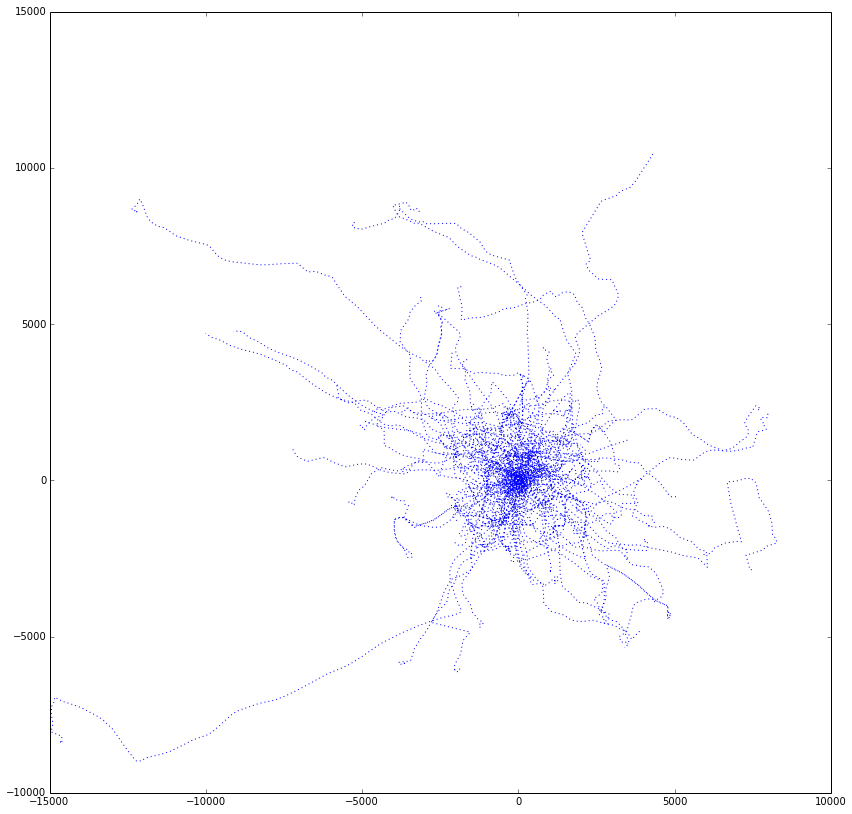

In [42]:
fig = plt.figure()
fig.set_figheight(14)
fig.set_figwidth(14)

for j in range(1):
    for i in range(200):
        trip = Trip('drivers/'+str(j+1000)+'/'+str(i+1)+'.csv')
        trip._load_data()
        plt.plot(trip.roadx, trip.roady, 'b:', label='')

1520
82
1226


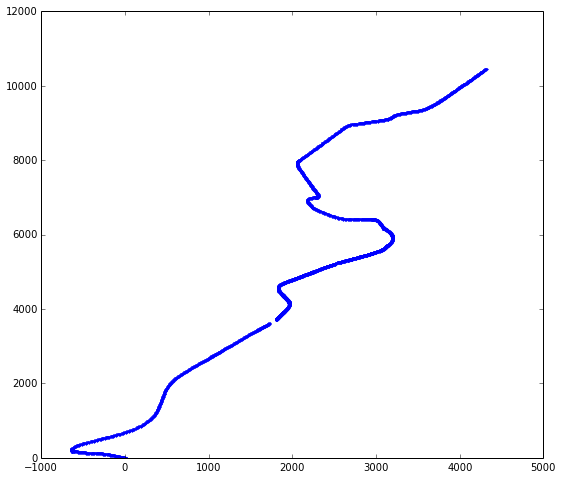

In [91]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(9)

#trip = Trip('drivers/1162/15.csv')
#trip = Trip('drivers/1000/119.csv')
trip = Trip('drivers/1000/49.csv')
#trip = Trip('drivers/1162/30.csv')
attributes = trip.get_features(True)
print len(trip.x0)
print len(trip.roadx)
print len(trip.x)
#plt.plot(trip.x0[-350:], trip.y0[-350:], 'b^', label='')
#plt.plot(trip.x0[-150:], trip.y0[-150:], 'b^', label='')
#plt.plot(trip.x[-15:], trip.y[-15:], 'ro', label='')
plt.plot(trip.x0, trip.y0, 'b.', label='')
#plt.plot(trip.roadx, trip.roady, 'ro', label='')
#plt.plot(trip.x, trip.y, 'g.', label='')

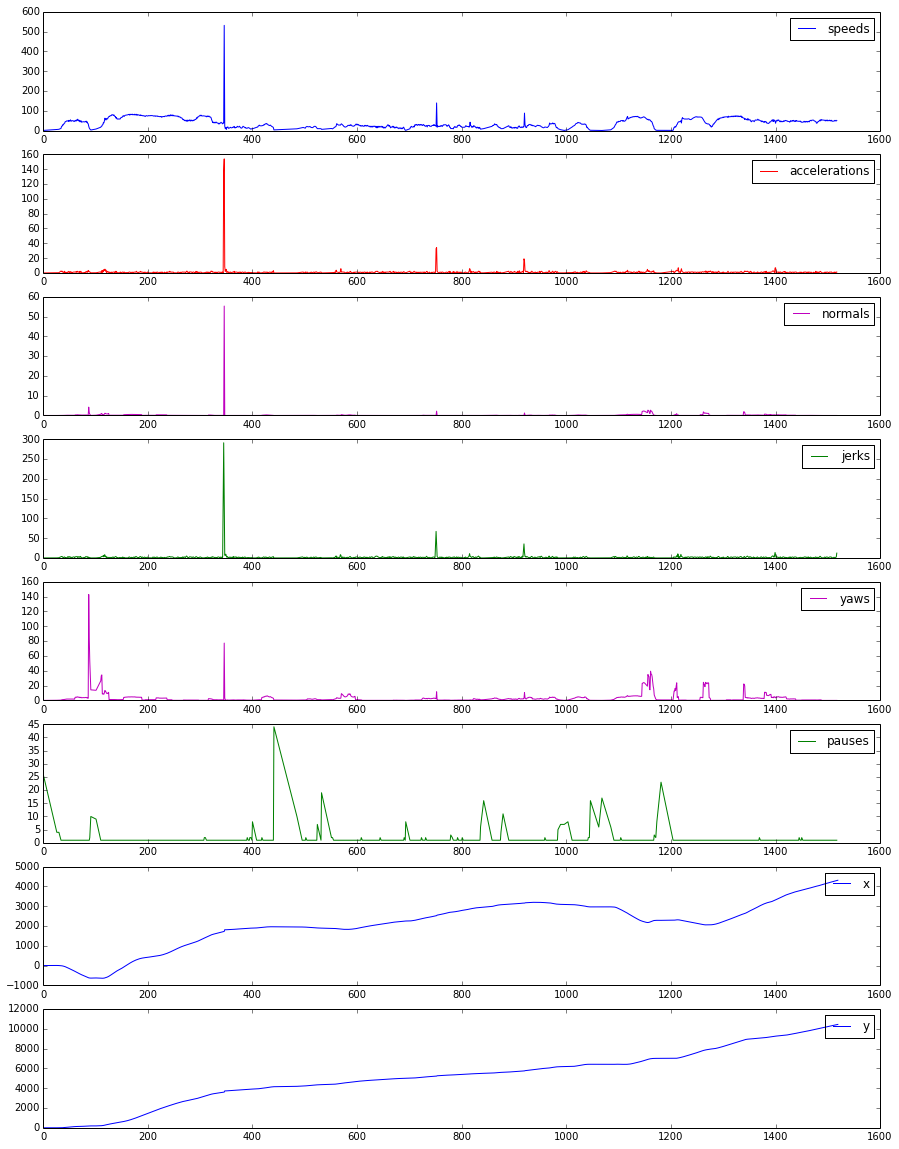

In [56]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(15)

plt.subplot(8,1,1)
plt.plot(trip.t[:-2], attributes['speeds'], 'b-', label='speeds')
#plt.plot(trip.t[:-2], attributes['speeds'], 'b^', label='speeds')
plt.legend(loc='upper right') 
plt.subplot(8,1,2)
plt.plot(trip.t[:-2], attributes['accelerations'], 'r-', label='accelerations')
plt.legend(loc='upper right') 
plt.subplot(8,1,3)
plt.plot(trip.t[:-2], attributes['normals'], 'm-', label='normals')
plt.legend(loc='upper right') 
plt.subplot(8,1,4)
plt.plot(trip.t[:-2], attributes['jerks'], 'g-', label='jerks')
plt.legend(loc='upper right') 
plt.subplot(8,1,5)
plt.plot(trip.t[:-2], attributes['yaws'], 'm-', label='yaws')
plt.legend(loc='upper right') 
plt.subplot(8,1,6)
plt.plot(trip.t[:-2], attributes['pauses'], 'g-', label='pauses')
plt.legend(loc='upper right') 
plt.subplot(8,1,7)
plt.plot(trip.t, trip.x, 'b-', label='x')
plt.legend(loc='upper right') 
plt.subplot(8,1,8)
plt.plot(trip.t, trip.y, 'b-', label='y')
plt.legend(loc='upper right') 

In [17]:
tmpdi, tmpsl, tmpr, tmpv, tmpa, tmpj, tmpan, tmpy, tmpp = [], [], [], [], [], [], [], [], []

for j in range(10):
    for i in range(200):
        
        #print 'drivers/'+str(j+1000)+'/'+str(i+1)+'.csv'
        trip = Trip('drivers/'+str(j+1000)+'/'+str(i+1)+'.csv')
        attributes = trip.get_features(True)

        tmpdi+=attributes['distances']
        tmpsl+=attributes['slip_angles']
        tmpr+=attributes['radiuses']

        tmpv+=attributes['speeds']
        tmpa+=attributes['accelerations']
        tmpan+=attributes['normals']
        tmpj+=attributes['jerks']
        tmpy+=attributes['yaws']
        tmpp+=attributes['pauses']

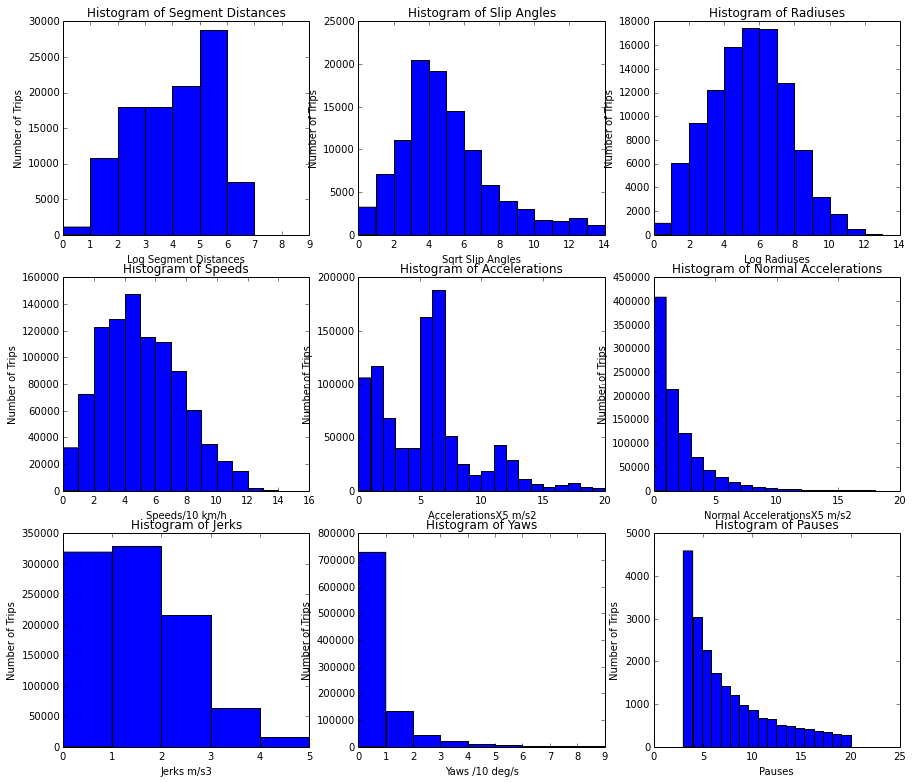

In [20]:
fig = plt.figure()
fig.set_figheight(13)
fig.set_figwidth(15)

plt.subplot(3,3,1)
plt.hist([log(x+1) for x in tmpdi], bins=np.linspace(0, 15, 16))
plt.title('Histogram of Segment Distances')
plt.ylabel('Number of Trips')
plt.xlabel('Log Segment Distances')

plt.subplot(3,3,2)
plt.hist([sqrt(x) for x in tmpsl], bins=np.linspace(0, 15, 16))
plt.title('Histogram of Slip Angles')
plt.ylabel('Number of Trips')
plt.xlabel('Sqrt Slip Angles')

plt.subplot(3,3,3)
plt.hist([log(x+1) for x in tmpr], bins=np.linspace(0, 15, 16))
plt.title('Histogram of Radiuses')
plt.ylabel('Number of Trips')
plt.xlabel('Log Radiuses')

plt.subplot(3,3,4)
plt.hist([x/10 for x in tmpv], bins=np.linspace(0, 15, 16))
plt.title('Histogram of Speeds')
plt.ylabel('Number of Trips')
plt.xlabel('Speeds/10 km/h')

plt.subplot(3,3,5)
plt.hist([x*5 for x in tmpa], bins=np.linspace(0, 20, 21))
plt.title('Histogram of Accelerations')
plt.ylabel('Number of Trips')
plt.xlabel('AccelerationsX5 m/s2')

plt.subplot(3,3,6)
plt.hist([x*5 for x in tmpan], bins=np.linspace(0, 20, 21))
plt.title('Histogram of Normal Accelerations')
plt.ylabel('Number of Trips')
plt.xlabel('Normal AccelerationsX5 m/s2')

plt.subplot(3,3,7)
plt.hist(tmpj, bins=np.linspace(0, 5, 6))
plt.title('Histogram of Jerks')
plt.ylabel('Number of Trips')
plt.xlabel('Jerks m/s3')

plt.subplot(3,3,8)
plt.hist([x/10. for x in tmpy], bins=np.linspace(0, 9, 10))
plt.title('Histogram of Yaws')
plt.ylabel('Number of Trips')
plt.xlabel('Yaws /10 deg/s')

plt.subplot(3,3,9)
plt.hist([x for x in tmpp], bins=np.linspace(3, 20, 19))
plt.title('Histogram of Pauses')
plt.ylabel('Number of Trips')
plt.xlabel('Pauses')

In [10]:
Trip('drivers/1000/119.csv').get_features(model='T1')['trace']
#Trip('drivers/1162/15.csv').get_features(True)['trace']
#Driver('drivers/1234').generate_features(model='T1')

u'd1L6Br1 d1L8Sr1 d1L5Sr2 d1L6Ur2 d2L8Ur2 d3L4Sr3 d2L5Ur3 d3L4Ur4 d3L6Sr4 d3L7Sr3 d4L4Ur5 d4L3Ur5 d4L2Ur7 d5L4Sr6 d3L3Ur5 d4L3Sr6 d5L4Ur6 d4L3Ur7 d5L9Sr5 d2L5Ur4 d3L2Ur7 d6L1Sr9 d5L0Sr9 d5L1Sr9 d5L7Ur5 d2L6Ur2 d2L3Ur5 d4L1Ur8 d5L2Ur7 d6L10Sr5 d6L8Sr5 d2L4Ur3 d3L3Ur6 d5L4Sr5 d4L5Ur6 d6L7Sr6 d6L2Ur8 d5L2Ur7 d5L2Ur7 d5L3Sr7 d5L3Ur6 d5L3Ur7 d6L5Sr6 d5L2Ur7 d5L5Sr5 d3L2Ur6 d5L1Ur8 d5L6Sr6 d5L4Ur6 d4L3Ur7 d5L3Sr6 d4L3Ur6 d5L4Sr5 d3L2Ur7 d5L3Ur6 d5L8Sr4 d2L4Ur4 d4L6Sr3 d2L5Ur3 d3L5Sr3 d3L5Ur4 d4L6Ur3 d2L6Ur2 d1L1Ur5 d3L3Ur4 d2L8Ur2'